# Spectrogram Segmentation

In this example, we use [PyTorch](https://pytorch.org/) and [Lightning](https://lightning.ai/docs/pytorch/stable/) to train deep learning models to differentiate between 5G NR and 4G LTE signals within wideband spectrograms.

## Outline

**[Background](#Background):** Delve into the problem background and learn more about the machine learning frameworks, tools, and datasets used in this example.

**[Set-up](#Set-Up):** Install the libraries and initialize the variables necessary to run the code in this notebook.

**[Data Preprocessing](#Data-Preprocessing):** Load and analyze the Spectrum Sensing dataset.

**[Model Training](#Model-Training):** Select and train a deep learning model.

**[Model Verification](#Model-Verification):** Assess the performance of the model using a suite of common machine learning metrics

**[Challenge Data](#Challange-Data):** Challenge the model on combined frames containing both LTE and NR signal.

**[Conclusions & Next Step](#Conculsions-&-Next-Steps):** Interpret the results, summarize key learnings, and identify next steps for expanding upon this example.

## Background

5G NR (New Radio) and 4G LTE (Long-Term Evolution) are both cellular network technologies, but they represent 
different generations of mobile network standards. The ability to identify and distinguish between the two holds significant 
applications in [spectrum sensing](https://iopscience.iop.org/article/10.1088/1742-6596/2261/1/012016) and serves as a foundational example showcasing the near-term feasibility of 
[intelligent radio](https://www.qoherent.ai/intelligentradio/) technology.

A spectrogram, which depicts the frequency spectrum of a signal over time, is essentially just an image. Therefore, we can
apply state-of-the-art [semantic segmentation](https://www.ibm.com/topics/semantic-segmentation) techniques from 
the field of computer vision to the problem of spectrogram analysis. Our task is to assign one of the 
following labels to each pixel in the spectrogram: 'LTE', 'NR', or 'Noise'. ('Noise' refers to the absence of signal, representing 
a vacant or empty spectrum, also known as whitespace.)

The machine learning models utilized in this example are DeepLabV3 models. The DeepLabv3 framework was originally introduced by Chen _et al._ in their 2017 paper titled '[Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1706.05587)'. For an accessible introduction to the DeepLabV3 framework, please check out Isaac Berrios' article: [DeepLabv3: Building Blocks for Robust Segmentation Models](https://medium.com/@itberrios6/deeplabv3-c0c8c93d25a4).

The dataset used in this example is the Spectrum Sensing dataset, provided by MathWorks. This dataset contains 900 LTE frames, 900 NR frames, and 900 combined frames with both LTE and NR signal. In this example, we train exclusively on the individual LTE and NR examples, excluding the combined frames.

To ensure comparability with results obtained using MathWorks' AI-based network, we use the hyperparameter configuration from MathWorks' spectrum sensing example: [Spectrum Sensing with Deep Learning to Identify 5G and LTE Signals](https://www.mathworks.com/help/comm/ug/spectrum-sensing-with-deep-learning-to-identify-5g-and-lte-signals.html).

# Set-Up

In this section, we will install the dependencies required to run the code in this notebook. These dependencies include libraries and packages for tasks such as data manipulation, visualization, and machine learning. Additionally, we will initialize a few variables.

In [ ]:
%matplotlib inline

In [ ]:
import glob
import os

import statistics
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import lightning as L
import torch
import torchmetrics
import torchvision
from osgeo import gdal
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from typing import Optional, Any
from torch import nn, Tensor
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex as jac_ind
from torchmetrics.classification import MulticlassAccuracy, MulticlassConfusionMatrix
from torchvision.datasets import VisionDataset
from torchvision.io import read_image
from torchvision.transforms.v2 import Compose, PILToTensor, ToDtype, Normalize, ToPILImage, ToTensor
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_mobilenet_v3_large

In [ ]:
title_font_size, label_font_size = 14, 12

# Data Preprocessing

In semantic segmentation, the input data typically consists of images (in this case, spectrograms), while the output data consists of pixel-wise labels (masks) where each pixel is assigned a category label (in this case, either 'LTE', 'NR', or 'Noise'). 

In this example, we use [supervised learning](https://www.ibm.com/topics/supervised-learning) techniques to train our model. These techniques require both input spectrograms and the corresponding target masks for training. For each frame in the dataset, we have two separate files:

- A `.png` file containing the spectrogram image to use as input to the model.

- A `.hdf` ([HDF4](https://www.hdfgroup.org/solutions/hdf4/)) file containing the target mask to use for training.

The Spectrum Sensing dataset also includes `.mat` files containing metadata such as the signal sample rate. However, none of this metadata is necessary for this example, so we can safely ignore these files.

Because spectrogram segmentation is a computer vision task, let's extend the [VisionDataset](https://pytorch.org/vision/main/generated/torchvision.datasets.VisionDataset.html) class.

In [ ]:
class SpectrumSensing(VisionDataset):

    def __init__(self, root: str, transform: Optional[callable] = None, target_transform: Optional[callable] = None):
        """Initialize the dataset, specifying the root directory where the dataset files are located."""
        super().__init__(root)

        self.root = root
        self.transform, self.target_transform = transform, target_transform

        # Parse the root directory and extract the basenames of individual LTE and NR frames.
        files = glob.glob(os.path.join(root, "*.png"))
        self.frames = [os.path.basename(frame).split(".")[0] for frame in files]

    def __len__(self) -> int:
        return len(self.frames)

    def __getitem__(self, idx: int) -> tuple[Image, Image]:
        """Return the image-mask pair at idx."""
        basename = self.frames[idx]

        image_file = os.path.join(self.root, f"{basename}.png")
        target_file = os.path.join(self.root, f"{basename}.hdf")

        image = Image.open(image_file)
        if self.transform is not None:
            image = self.transform(image)

        mask_data = gdal.Open(target_file)
        mask_band = mask_data.GetRasterBand(1)
        mask = (Image.fromarray(mask_band.ReadAsArray())).convert(mode="L")
        if self.target_transform is not None:
            mask = self.target_transform(mask)

        return image, mask

Notice our `SpectrumSensing` class accepts two functions/transforms: `transform`, which is applied to the spectrogram, 
and `target_transform`, which is applied to the mask.

Both the spectrograms and masks are 256 x 256 pixel images. However, the spectrograms are three channeled, while the masks are single-channeled. This is because the spectrograms are full RGB images, whereas the masks are ternary-valued images, where each pixel takes one of three discrete values:
- `0`: Represents noise.
- `127`: Representing 5G NR signal.
- `255`: Representing 4G LTE signal.

To prepare our spectrograms for training, we will convert them from PIL Images to Tensor objects. As required by our models, the images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. To prepare our masks for training, we will convert them to Tensor objects, remove the extraneous channel dimension, and update the pixel values so that `0` respresents noise, `1` represents NR signal, and `2` represents LTE signal.

In [ ]:
project_root = os.getcwd()
data_root = os.path.join(project_root, "SpectrumSensingDataset", "TrainingData")

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

class Squeeze(torch.nn.Module):
    def forward(self, target: Tensor):
        return torch.squeeze(target)


class DivideBy127(torch.nn.Module):
    def forward(self, target: Tensor):
        return torch.div(target, 127, rounding_mode="floor")
        
transform = Compose(
    [
        PILToTensor(),
        ToDtype(
            torch.float, scale=True
        ), 
        Normalize(mean=mean, std=std),
    ]
)

target_transform = Compose(
    [
        PILToTensor(), 
        Squeeze(), 
        DivideBy127(),  # Mapping 0 -> 0, 127 -> 1, and 255 -> 2.
        ToDtype(torch.long)
    ]
)

With that done, let's initialize the dataset, and take a closer look at a random training example and the corresponding mask. Due to our transforms, we expect that the image-mask pair will be returned as Tensor objects.

In [ ]:
dataset = SpectrumSensing(root=data_root, transform=transform, target_transform=target_transform)

In [151]:
random_index = np.random.randint(len(dataset))
training_example, corresponding_mask = dataset[random_index]

print(f"The full dataset has {len(dataset)} examples. Loading example at index {random_index}:")
print(f"Spectrogram: {type(training_example)}, {training_example.dtype}, {training_example.size()}")
print(f"Mask: {type(corresponding_mask)}, {corresponding_mask.dtype}, {corresponding_mask.size()}")

The full dataset has 1800 examples. Loading example at index 497:
Spectrogram: <class 'torch.Tensor'>, torch.float32, torch.Size([3, 256, 256])
Mask: <class 'torch.Tensor'>, torch.int64, torch.Size([256, 256])


The dataset should contain 1,800 samples: 900 NR fames and 900 LTE frames. 

To get a better idea of what's going on, let's write some tranforms undo the previous normalization and prepare this image-mask pair for viewing. And, let's build a custom colormap for the masks, with noise as cyan, NR signal as blue, and LTE signal as purple.

In [152]:
inv_transform = Compose(
    [
        Normalize(mean=[0.0, 0.0, 0.0], std=[1 / x for x in std]),
        Normalize(mean=[-x for x in mean], std=[1.0, 1.0, 1.0]),
        ToPILImage(),
    ]
)

inv_target_transform = Compose(
    [
        ToDtype(dtype=torch.uint8),
        ToPILImage()
    ]
)

training_example = inv_transform(training_example)
corresponding_mask = inv_target_transform(corresponding_mask)

values, labels, colors = [0, 1, 2], ["Noise", "NR", "LTE"], ["cyan", "blue", "purple"]
mask_cmap = ListedColormap(colors)

print(f"Spectrogram: {training_example}")
print(f"Mask: {corresponding_mask}")

Spectrogram: <PIL.Image.Image image mode=RGB size=256x256 at 0x2886F5F37D0>
Mask: <PIL.Image.Image image mode=L size=256x256 at 0x2886F5BF9D0>


[Text(1, 0.33, 'Noise'), Text(1, 1.0, 'NR'), Text(1, 1.67, 'LTE')]

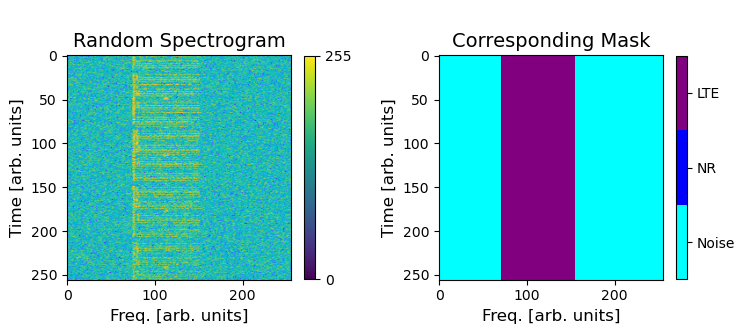

In [155]:
fig, (ax1, ax2) = plt.subplots(figsize=[8, 3.5], nrows=1, ncols=2)
plt.subplots_adjust(wspace=0.5)
ax1.set_title("\nRandom Spectrogram", fontsize=title_font_size)
ax2.set_title("Corresponding Mask", fontsize=title_font_size)
ax1.set_ylabel("Time [arb. units]", fontsize=label_font_size)
ax2.set_ylabel("Time [arb. units]", fontsize=label_font_size)
ax1.set_xlabel("Freq. [arb. units]", fontsize=label_font_size)
ax2.set_xlabel("Freq. [arb. units]", fontsize=label_font_size)

spect = ax1.imshow(training_example, vmin=0, vmax=255)
fig.colorbar(spect, ax=ax1, fraction=0.045, ticks=[0, 255])

mask = ax2.imshow(corresponding_mask, cmap=mask_cmap, vmin=0, vmax=2)
mask_cbar = fig.colorbar(mask, ax=ax2, cmap=mask_cmap, fraction=0.045, ticks=[0.33, 1, 1.67])
mask_cbar.ax.set_yticklabels(labels)

**Note:** You can view different examples from the dataset by rerunning the previous few code cells.

Let's analyze the relative frequencies of the different class labels. This step is critical for identifying imbalance in our dataset. Please note that the following code block might take a few seconds to run.

In [ ]:
class_counts = {label: 0 for label in labels}

for _, mask in dataset:
    arr = np.asarray(mask)
    for i, label in enumerate(labels):
        class_counts[label] += np.sum(arr == values[i])

normalized_counts = np.array(list(class_counts.values())) / sum(list(class_counts.values()))

plt.bar(class_counts.keys(), normalized_counts, tick_label=labels, color=colors)
plt.title("Distribution of Pixel Counts by Class", fontsize=title_font_size)
plt.xlabel("Class", fontsize=label_font_size)
plt.ylabel("Counts (Normalized)", fontsize=label_font_size)

It looks like most of our data is noise! A classification dataset like this—with skewed class proportions—is called imbalanced.

An imbalanced dataset can result in biased and poorly performing models. Models trained on imbalanced data tends to focus more on the majority classes and may not learn enough about the minority classes. In our case, the majority class is noise, while the minority classes are the NR and LTE signals we want to identify and classify. To ensure the development of a fair, accurate, and robust model, we will need to address this class imbalance. 

But first, let's split the dataset into separate training and validation sets. The training dataset is the portion of the dataset that will be used to train the model, while the validation dataset will be held in reserve and used to evaluate the performance of the trained model. Let's start with a simple 80/20 split, where 80% of the dataset is used for training and 20% for validation.

In [ ]:
train_split = 0.80
n_train_examples = int(len(dataset) * train_split)
n_val_examples = len(dataset) - n_train_examples

train_set, val_set = torch.utils.data.random_split(
    dataset=dataset, lengths=[n_train_examples, n_val_examples], generator=torch.Generator().manual_seed(42)
)

print(f"The training split contains {len(train_set)} examples.")
print(f"The validation split contains {len(val_set)} examples.")

In machine learning, data loaders facilitate easy access to samples, efficiently load and batch data, and offer numerous other features to streamline data preprocessing, management, and integration within the training loop. Let's create data loaders for both the training and validation datasets.

In PyTorch, the `DataLoader` class allows us to pass a `batch_size` argument, which controls the number of samples used in each pass through the network. Using a small number of training examples each pass is called mini-batching, and can improve efficiency, stabilize training dynamics, and enable scalable training on large datasets. Choosing an appropriate mini-batch size depends on several factors, including the available memory on your hardware, training efficiency constraints, and generalization requirements. However, as with everything in machine learning, we ultimately rely on empirical testing to determine the optimal configuration that maximizes model performance for each specific task and dataset. In this example, we'll start with mini-batches containing 4 samples each, which will easily fit on any CPU/GPU without issue.

In [156]:
mini_batch_size = 4

train_loader = DataLoader(train_set, batch_size=mini_batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=mini_batch_size, shuffle=False)

spects, masks = next(iter(train_loader))

print(f"Batch of spectrograms: {type(spects)}, {spects.dtype}, {spects.size()}")
print(f"Batch of masks: {type(masks)}, {masks.dtype}, {masks.size()}")

Batch of spectrograms: <class 'torch.Tensor'>, torch.float32, torch.Size([4, 3, 256, 256])
Batch of masks: <class 'torch.Tensor'>, torch.int64, torch.Size([4, 256, 256])


Let's examine a batch of spectrograms along with their corresponding masks. Note that the following plotting code is optimized for small batch sizes and may not render as nicely with larger batch sizes.

In [157]:
def plot_spects(spects: list[Image.Image]) -> None:
    fig, axes = plt.subplots(figsize=[mini_batch_size * 2, 3], nrows=1, ncols=mini_batch_size, sharey=True)
    fig.text(0.5, 0.75, "Spectrograms", fontsize=title_font_size, ha="center")
    axes[0].set_ylabel("Time [arb. units]", fontsize=label_font_size)
    fig.text(0.5, 0.12, "Freq. [arb. units]", fontsize=label_font_size, ha="center")

    for i, ax in enumerate(axes):
        im = ax.imshow(spects[i], vmin=0, vmax=255)

    fig.subplots_adjust(right=0.90)
    cbar_ax = fig.add_axes(rect=[0.93, 0.24, 0.02, 0.5])
    fig.colorbar(im, cax=cbar_ax, ticks=[0, 255])


def plot_masks(masks: list[Image.Image], prediction: bool = False) -> None:
    fig, axes = plt.subplots(figsize=[mini_batch_size * 2, 3], nrows=1, ncols=mini_batch_size, sharey=True)
    if prediction:
        fig.text(0.5, 0.75, "Model Predictions", fontsize=title_font_size, ha="center")
    else:
        fig.text(0.5, 0.75, "Masks", fontsize=title_font_size, ha="center")
    axes[0].set_ylabel("Time [arb. units]", fontsize=label_font_size)
    fig.text(0.5, 0.12, "Freq. [arb. units]", fontsize=label_font_size, ha="center")

    for i, ax in enumerate(axes):
        im = ax.imshow(masks[i], vmin=0, vmax=2, cmap=mask_cmap)

    fig.subplots_adjust(right=0.90)
    cbar_ax = fig.add_axes(rect=[0.93, 0.24, 0.02, 0.5])
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0.33, 1, 1.66])
    cbar.ax.set_yticklabels(labels)

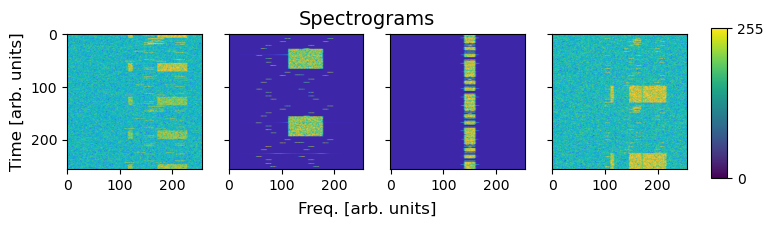

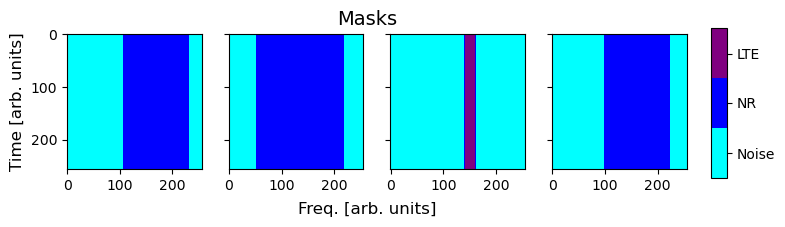

In [158]:
plot_spects(spects=[inv_transform(i) for i in spects])
plot_masks(masks=[inv_target_transform(i) for i in masks])

# Model Training

Let's start by choosing a model. For this example, we suggest choosing between DeepLabV3 models with ResNet-50 or MobileNetV3 backbones. ResNet-50 is the deeper and more complex, and generally offers better model performance, whereas MobileNetV3 is designed to be lightweight and efficient. Because both models provide the same interface, and either will work with this example.

Note: DeepLabV3 also provides a deeper ResNet-101 model. Feel free to experiment with it if you're interested, but we suggest 101 layers is  overkill for the task at hand and likely requires a larger dataset to train effectively.

In [ ]:
n_classes = 3  # We are dealing with three classes: Noise, NR, and LTE.

# model = deeplabv3_resnet50(num_classes=n_classes)
model = deeplabv3_mobilenet_v3_large(num_classes=n_classes)

Next, we need a loss function. A loss function, also known as a cost or objective function, measures how well a machine learning 
model's predictions match the actual target values. This quantifies the error between predicted outputs and ground truth labels, providing
feedback that guides the model's training process. For classification problems, we commonly use the [Cross-Entropy Loss](https://machinelearningmastery.com/cross-entropy-for-machine-learning/), especially for 
multi-class classification problems. Let's use the [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) class from PyTorch, which allows us to assign different weights to individual classes during the computation of the loss. 

We'll use weights inversly propotional to the relative pixel count for each class. That way, we assign lower weights to overrepresented classes, like noise, and larger weights to underrepresented classes, like LTE signal. This reduces the impact of noise and allows the model to prioritize learning from NR and especially LTE samples. Class weighting is not the only way to address data imblance, but it is one of the more straightforward methods.

In [ ]:
median_count = statistics.median(list(class_counts.values()))
weight = [median_count / class_counts[k] for k in class_counts.keys()]
loss_function = nn.CrossEntropyLoss(weight=torch.tensor(weight, dtype=torch.float))

print("Class weights: ", {k: round(weight[i], 2) for i, k in enumerate(class_counts.keys())})

In this example, we will train out model using stochastic gradient descent (SGD). SGD is a variant of the standard [gradient descent](https://builtin.com/data-science/gradient-descent) optimizer where the loss function is computed on mini-batches of data rather than the entire dataset. This helps improve computational efficiency and scalability, particularly for large datasets, by updating model parameters based on the gradients computed on our mini-batches.

We'll define the training and validation process of our segmentation model in a [`LightningModule`](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#lightningmodule). 

In [ ]:
class SegmentationSGD(L.LightningModule):
    """LightningModule for training and evaluating a segmentation model using the SGD optimizer. """

    def __init__(
        self,
        model: nn.Module,
        loss_function: nn.Module,
        n_classes: int,
        learning_rate: float,
        momentum: float,
        weight_decay: float,
        step_size: int,
        gamma: float,
    ):
        """Initializes the SegmentationSGD module."""
        super().__init__()
        self.model = model
        self.loss_function = loss_function
        self.n_classes = n_classes

        self.learning_rate = learning_rate
        self.momentum = momentum
        self.weight_decay = weight_decay

        self.step_size = step_size
        self.gamma = gamma

        self.train_accuracy = MulticlassAccuracy(num_classes=self.n_classes)
        self.val_accuracy = MulticlassAccuracy(num_classes=self.n_classes)

    def forward(self, x: Tensor) -> Tensor:
        """Defines a forward pass through the model."""
        return self.model(x)

    def training_step(self, batch: Tensor, batch_idx: int) -> Tensor:
        """Defines a single training step."""
        image, target = batch
        preds = self(image)['out']
        loss = self.loss_function(preds, target)
        self.train_accuracy(preds, target)
        return loss

    def on_train_epoch_end(self):
        """Logs the training accuracy and loss metrics at the end of each training epoch."""
        self.log(name="train_accuracy", value=self.train_accuracy, prog_bar=True)
        self.log(name="train_loss", value=loss, on_epoch=True, prog_bar=True)

    def validation_step(self, batch: Tensor, batch_idx: int) -> Tensor:
        """Defines a single validation step."""
        image, target = batch
        preds = self(image)['out']
        loss = self.loss_function(preds, target)
        self.val_accuracy(preds, target)
        return loss

    def on_validation_epoch_end(self):
        """Logs the training accuracy and loss metrics at the end of each validation epoch."""
        self.log(name="val_accuracy", value=self.val_accuracy, prog_bar=True)
        self.log(name="val_loss", value=loss, on_epoch=True, prog_bar=True)

    def configure_optimizers(self) -> dict[str, Any]:
        """Configure the optimizer and learning rate scheduler."""
        optimizer = torch.optim.SGD(
            self.parameters(), lr=self.learning_rate, momentum=self.momentum, weight_decay=self.weight_decay
        )
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=self.step_size, gamma=self.gamma)

        return {
            "optimizer": optimizer, 
            "lr_scheduler": lr_scheduler
        }

Our `SegmentationModelSGD` is initialized with several configuration settings that influence the behavior and performance of the machine learning algorithm or model. These parameters are called hyperparameters, and unlike model parameters, which are learned from the data during training, hyperparameters are set prior to training and influence the learning process.

The following hyperparameters are used to configure the optimizer:
- **Momentum:** A parameter that accelerates SGD in the relevant direction and dampens oscillations.
- **Learning Rate:** The rate at which the model parameters are updated during optimization.
- **Weight Decay:** A regularization term added to the loss function to penalize large weights in the model to prevent overfitting

By gradually reducing the learning rate over epochs, the scheduler can help improve the convergence and stability of the optimization process
We need to provide the following two parameters, which the learning rate scheduler uses to dynamically adjust the learning rate during training:
- **Step Size:** The number of epochs after which the learning rate is reduced.
- **Gamma:** The factor by which the learning rate is reduced after every step-size epochs.

Adjusting these hyperparameters can significantly impact the training process and the final performance of the model, for better or for worse!

In [ ]:
segmentation_module = SegmentationSGD(
    model=model,
    loss_function=loss_function,
    n_classes=n_classes,
    learning_rate=0.02,  # Represents the initial learning rate.
    momentum=0.9,
    weight_decay=1.0e-04,
    step_size=10,
    gamma=0.1,
)

In [ ]:
# TODO: This is just a testing block, to be removed once the tutorial is complete
model.eval()  # Set the model to evaluation mode
inputs, targets = next(iter(train_loader))

with torch.no_grad():
    # Forward pass with the input data
    preds = model(inputs)["out"]

print("Initial model predictions:")
print(preds.size())
print("\tPrediction max: ", torch.max(preds))
print("\tPrediction min: ", torch.min(preds))

print("\tMax value in target: ", torch.max(targets.long()))
print("\tMin value in target: ",torch.min(targets.long()))
loss = loss_function(preds, targets.long())
print("Loss: ", loss)

# Convert preds to Image for viewing
print("After converting back to images for viewing:")
print("Predictions: ", preds.size())

# Need to find the classes with the largest probability.
# Take the maximum value along the class axis.
output = preds.argmax(1)

print("Output: ", output.size())

fig, axes = plt.subplots(figsize=[mini_batch_size * 2, 3], nrows=1, ncols=mini_batch_size, sharey=True)
axes[0].set_ylabel("Time [s]", fontsize=label_font_size)
fig.text(0.5, 0.12, "Freq. [arb. units]", fontsize=label_font_size, ha="center")

for i, ax in enumerate(axes):
    ax.set_title("Prediction " + str(i + 1))
    im = ax.imshow(output[i], vmin=0, vmax=2, cmap=mask_cmap)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes(rect=[0.90, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0.33, 1, 1.66])
cbar.ax.set_yticklabels(labels)

fig, axes = plt.subplots(figsize=[mini_batch_size * 2, 3], nrows=1, ncols=mini_batch_size, sharey=True)
axes[0].set_ylabel("Time [s]", fontsize=label_font_size)
fig.text(0.5, 0.12, "Freq. [arb. units]", fontsize=label_font_size, ha="center")

for i, ax in enumerate(axes):
    ax.set_title("Mask " + str(i + 1))
    im = ax.imshow(targets[i], vmin=0, vmax=2, cmap=mask_cmap)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes(rect=[0.90, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0.33, 1, 1.66])
cbar.ax.set_yticklabels(labels)

Now that we have our model, weighted loss function, and Lightning Module, we are prepared to train our model. If available, we will leverage GPU acceleration for training. Otherwise, the training process will default to using the CPU. Please be patient; model training time may vary depending on the current hardware configuration and could take a few minutes.

The number of epochs determines how many times the entire dataset will be used to train the model. We will begin training with 20 epochs.

In [ ]:
n_epochs = 10

if torch.cuda.is_available():
    print("Training model on GPU.")
    trainer = L.Trainer(accelerator="gpu", max_epochs=n_epochs, logger=True)
    device = "cuda"
else:
    print("Training model on CPU.")
    trainer = L.Trainer(max_epochs=n_epochs, logger=True)
    device = "cpu"

print(len(train_loader))
trainer.fit(model=segmentation_module, train_dataloaders=train_loader, val_dataloaders=val_loader)

# Model Verification

Having trained our model, the next step is to evaluate its performance. To accomplish this, we'll use a suite of standard machine learning metrics. But first, let's take quick look at a random batch of predictions and true labels.

Because the model returns the unnormalized probabilities corresponding to the predictions of each class. We need to use `argmax()` to get the maximum prediction of each class. The result is a ternary-valued image for each example in the batch.

In [159]:
model.eval()
model.to(device)

spects, masks = next(iter(train_loader))
spects = spects.to(device)

with torch.no_grad():
    preds = (model(spects)["out"]).argmax(1)

print("Predictions:", preds.size())

Predictions: torch.Size([4, 256, 256])


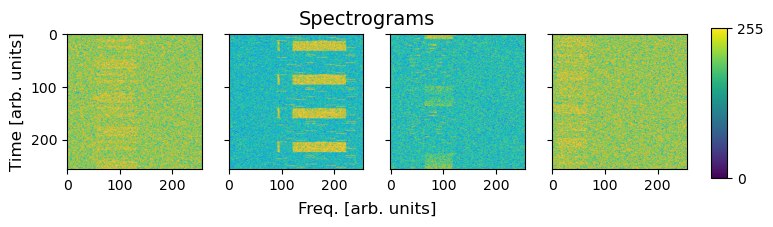

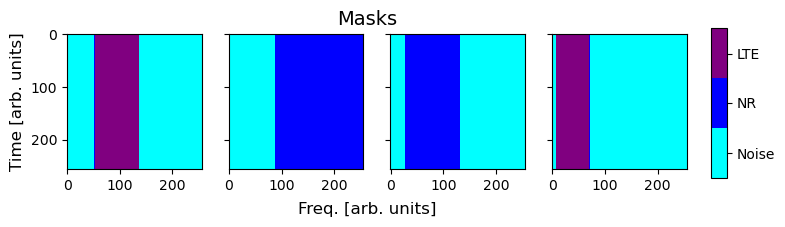

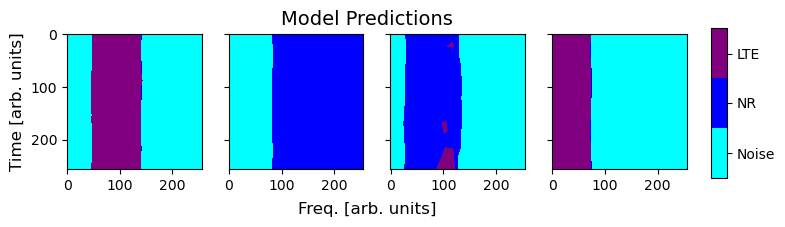

In [160]:
plot_spects(spects=[inv_transform(i.cpu()) for i in spects])
plot_masks(masks=[inv_target_transform(i) for i in masks])
plot_masks(masks=preds.cpu(), prediction=True)

Looks pretty good! To get a more ojective sense, 

Let's start with the confusion matrix, which provides a comprehensive overview of the model's ability. The diagonal elements represent the correct predictions and off-diagonal elements indicate prediction errors.

In [ ]:
def confusion_matrix(
    model: nn.Module, val_loader: DataLoader, n_classes: int, device: str, normalize: Optional[str] = "true"
) -> MulticlassConfusionMatrix:
    """Compute the confusion matrix for a given model using the validation dataset."""
    conf_matrix = (MulticlassConfusionMatrix(num_classes=num_classes, normalize=normalize)).to(device)
    model.to(device)
    model.eval()

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            pred = (model(x)["out"]).argmax(dim=1)
            conf_matrix.update(pred, y)

    return conf_matrix

In [ ]:
conf_matrix = confusion_matrix(model=segmentation_module, val_loader=val_loader, n_classes=n_classes, device=device)

fig, ax = plt.subplots(1, figsize=(3, 3))
ax.set_title("Confusion Matrix", fontsize=title_font_size)
ax.set_xlabel("True label", fontsize=label_font_size)
ax.set_ylabel("Predicted label", fontsize=label_font_size)

displ = ConfusionMatrixDisplay(np.array(torch.round(conf_matrix.compute(), decimals=2).to("cpu")))
displ.plot(ax=ax, colorbar=False)

Next, let's examine the model accuracy, calculated as the ratio of correctly predicted pixels to the total number of pixels. However, it's important to note that accuracy alone doesn't tell the whole story. Due to the imbalance in our dataset, a high accuracy can be achieved by always predicting  noise.

In [ ]:
segmentation_module.eval()
scores = trainer.validate(segmentation_module, val_loader)

### _Histogram of Intersection over Union (IoU) Scores per Image_

Let's generate a more comprehensive report, complete with the following metrics:

- Recall: The recall (sensitivity) measures the ability of the model to identify all relevant pixels.

- Precision: The precision assesses the accuracy of positive predictions.

- F1 Score: The F1 score combines both recall and precision into a single value, providing a more balanced measure of the model's performance.

- Intersection over Union (IoU): The IoU quantifies the overlap between the predicted bounding box or segmented region and the ground truth bounding box or annotated region from a dataset. A higher IoU value indicates a better alignment between the predicted and actual regions, reflecting a more accurate model.

In [ ]:
def compute_metric(model, loader, metric_name, num_classes, device):
    metric = getattr(torchmetrics.classification, metric_name)
    metric_per_class = metric(num_classes=num_classes, average="none").to(device)
    average_metric = metric(num_classes=num_classes, average="macro").to(device)
    weighted_metric = metric(num_classes=num_classes, average="weighted").to(device)
    model.to(device)
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            pred = (model(x)["out"]).argmax(dim=1)
            pred = pred.to(device)
            metric_per_class.update(pred, y)
            average_metric.update(pred, y)
            weighted_metric.update(pred, y)

    value_per_class = metric_per_class.compute()
    average_value = average_metric.compute()
    weighted_value = weighted_metric.compute()
    return value_per_class, average_value.unsqueeze(0), weighted_value.unsqueeze(0)

In [ ]:
metric_names = ["MulticlassRecall", "MulticlassPrecision", "MulticlassF1Score", "MulticlassJaccardIndex"]

metric_results = {
    metric_name: torch.hstack(compute_metric(segm_sgd_model, val_loader, metric_name, NUM_CLASSES, device))
    for metric_name in metric_names
}

In [ ]:
metric_results_cpu = {key: (value.to("cpu")).numpy() for key, value in metric_results.items()}

classification_report = pd.DataFrame(metric_results_cpu)

index = ["Noise", "NR", "LTE", "macro avg", "weighted avg"]
columns = ["Recall", "Precision", "F1 Score", "IoU"]

classification_report.columns = columns
classification_report.index = index

print(classification_report)

Finally, let's look at a histogram of IoU Scores per Image.

In [ ]:
def plot_hist(model, loader, device):
    iou_scores = []
    model.to(device)
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            pred = (model(x)["out"]).argmax(dim=1)
            jaccard = jac_ind(task="multiclass", num_classes=3).to(device)
            score = jaccard(pred.to(device), y)
            iou_scores.append(score.item())

    plt.hist(iou_scores, color="green", histtype="bar")
    plt.xlabel("IoU", color="blue")
    plt.ylabel("Number of Masks", color="blue")
    plt.title("Mean IoU", color="blue")

In [ ]:
new_val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)  # Changed the batch_size
plot_hist(segmentation_module, new_val_loader, device)

# Signal Identification in Spectrograms

In [ ]:
def signal_label(mask) -> str:
    """
    :param mask: The mask image containing signal labels.

    :return: The signal label based on unique labels in the mask.
    """
    labels = {0: "Noise", 1: "NR", 2: "LTE"}
    unique_labels_in_mask = torch.unique(mask)

    if len(unique_labels_in_mask) == 2:
        key = torch.unique(mask)[1].item()
        return labels[key]

    elif len(unique_labels_in_mask) == 3:
        key_1 = torch.unique(mask)[1].item()
        key_2 = torch.unique(mask)[2].item()
        return labels[key_1] + "_" + labels[key_2]

    else:
        key = torch.unique(mask)[0].item()

In [ ]:
def plot_spectrogram_mask(image, mask: Image, target: Image = None):

    if target is not None:
        fig, ax = plt.subplots(3, 1, figsize=(4, 10))

        ax[0].imshow(torch.permute(image, (1, 2, 0)))
        ax[0].set_xlabel("Frequency", fontsize=12, color="blue")
        ax[0].set_ylabel("Time", fontsize=12, color="blue")
        ax[0].set_title(f"Received Spectrogram ({signal_label(target)})", color="blue")

        ax[1].set_ylabel("Time", fontsize=12, color="blue")
        ax[1].set_xlabel("Frequency", fontsize=12, color="blue")
        ax[1].imshow(target)
        ax[1].set_title(f"True Signal Label ({signal_label(target)})", color="blue")

        ax[2].imshow(mask)
        # plt.imshow(predicted_image.permute(1,2,0)[:,:,0])
        # or equivalently
        # plt.imshow(pred['out'][0][0].to('cpu').detach())
        ax[2].set_xlabel("Frequency", fontsize=12, color="blue")
        ax[2].set_ylabel("Time", fontsize=12, color="blue")
        ax[2].set_title(f"Prediction ({signal_label(mask)})", color="blue")
        plt.tight_layout()

    else:
        fig, ax = plt.subplots(2, 1, figsize=(4, 10))

        ax[0].imshow(torch.permute(image, (1, 2, 0)))
        ax[0].set_xlabel("Frequency", fontsize=12, color="blue")
        ax[0].set_ylabel("Time", fontsize=12, color="blue")
        ax[0].set_title("Received Spectrogram", color="blue")

        ax[1].imshow(mask)
        # plt.imshow(predicted_image.permute(1,2,0)[:,:,0])
        # or equivalently
        # plt.imshow(pred['out'][0][0].to('cpu').detach())
        ax[1].set_xlabel("Frequency", fontsize=12, color="blue")
        ax[1].set_ylabel("Time", fontsize=12, color="blue")
        ax[1].set_title(f"Prediction ({signal_label(mask)})", color="blue")
        plt.tight_layout()

In [ ]:
image, target = next(iter(val_loader))  # First batch of spectrograms

In [ ]:
image, target = image.to(device), target.to(device)
segm_sgd_model.eval()
with torch.no_grad():
    predicted_masks = segm_sgd_model(image)["out"]
    first_mask_in_batch = predicted_masks[0].argmax(dim=0)

first_image_in_batch = image[0]
first_target_in_batch = target[0]

In [ ]:
plot_spectrogram_mask(first_image_in_batch.to("cpu"), first_mask_in_batch.to("cpu"), first_target_in_batch.to("cpu"))

# Challenge Data

TODO: Testing Model with Combined (NR_LTE) Signals

Recall combined frames with both NR and LTE signals were excluded from the training dataset.

In [ ]:
# Grab the first NR_LTE signal
PATH_TO_MATLAB5G_TRAINING_DATA = os.getcwd()
spec_path = os.path.join(PATH_TO_MATLAB5G_TRAINING_DATA, "LTE_NR", "LTE_NR_frame_0.png")
spectrogram = read_image(spec_path)  # Image has both NR and LTE signal
spectrogram = spectrogram.to(device)

segm_sgd_model.eval()
with torch.no_grad():
    pred = segm_sgd_model((spectrogram.to(torch.float)).unsqueeze(0))["out"]
    mask = pred[0].argmax(dim=0)

In [ ]:
plot_spectrogram_mask(spectrogram.to("cpu"), mask.to("cpu"))

# Conclusions & Next Steps

In this example, we used PyTorch and PyTorch Lightning to train DeepLabV3 models to identify and differentiate between 5G NR and 4G LTE signals within wideband spectrograms, showcasing one of the ways we can leverage machine learning to identify things in the wireless spectrum. This involved data analysis and preprocessing, model selection, choosing a loss function and optimizer, model training, model performance validation, and finally testing the model's generalization on combined frames containing both NR and LTE signals, 

The capability to differentiate and recognize various signals finds direct applications in spectrum sensing, which is fundamental to autonomous spectrum management, and brings us one step closer to more holistic cognitive radio solutions! 📡🚀

We hope this example was informative. Here are some next steps you can take to further explore and expand upon what you've learned:

- **Experiment with the Hyperparameters:** Adjust the values of hyperparameters such as the number of training epochs, mini-batch size, and learning rate, and observe how these configurations influence model training and performance. After gaining insights through manual hyperparameter tuning, explore automated approaches using tools like [Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) or [Optuna](https://optuna.org/).

- **Explore Alternative Solutions to Class Imbalance:** In this example, we addressed class imbalance in our dataset using a weighted cross-entropy loss function. Research and implement alternative strategies or loss functions designed to address imbalance in image datasets.

- **Integrate Combined Frames:** In this example, we trained exclusively on the individual NR and LTE frames. Try integrating the combined frames that contain both the NR and LTE signals into the training process, and evaluate the effect on model performance and generalization.

- **Test your Model on Captured Radio Data:** If you have radio hardware available, consider testing your model on real recordings of live radio data. Check out this article from MathWorks for more information on how to capture 5G NR and LTE signals: [Capture and Label NR and LTE Signals for AI Training](https://www.mathworks.com/help/wireless-testbench/ug/capture-and-label-nr-and-lte-signals-for-ai-training.html).

- **Explore RIA Core on GitHub:** At Qoherent, we're building [Radio Intelligence Applications](https://qoherent.ai/radiointelligenceapps-project/) (RIA) to drive the creation of intelligent radios. Check out [RIA Core](https://github.com/qoherent/ria)—the free and open-source foundation of RIA—and consider contributing to the project.